In [475]:
import decoupler as dc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from sklearn.metrics import roc_curve, auc

In [476]:
# Generate simulated data
!uv run sim_data_generator.py simulated_data/parameters.json

{'output_dir': 'simulated_data/', 'output_exp_file': 'simulated_scRNASeq_data.tsv', 'output_prior_file': 'simulated_prior_data.tsv', 'output_ground_truth_file': 'simulated_ground_truth.tsv', 'n_cells': 1500, 'n_genes': 1500, 'n_tfs': 70, 'ground_truth_activation_prob': 0.05, 'ground_truth_inactivation_prob': 0.05, 'include_tfs_in_expression': False, 'min_num_of_targets_per_tf': 10, 'max_num_of_targets_per_tf': 150, 'prediction_difficulty': 'superhard', 'missing_percentage': 90, 'random_seed': 42}
Generating prior data...
Generating gene expression data...
Wrote prior to simulated_prior_data.tsv
Wrote ground truth to simulated_ground_truth.tsv
Wrote gene expression to simulated_scRNASeq_data.tsv


Cells, Genes:(1500, 1500) and 1% Cells: 15
Wrote simulated_data/simulated_scRNASeq_data_stats.tsv


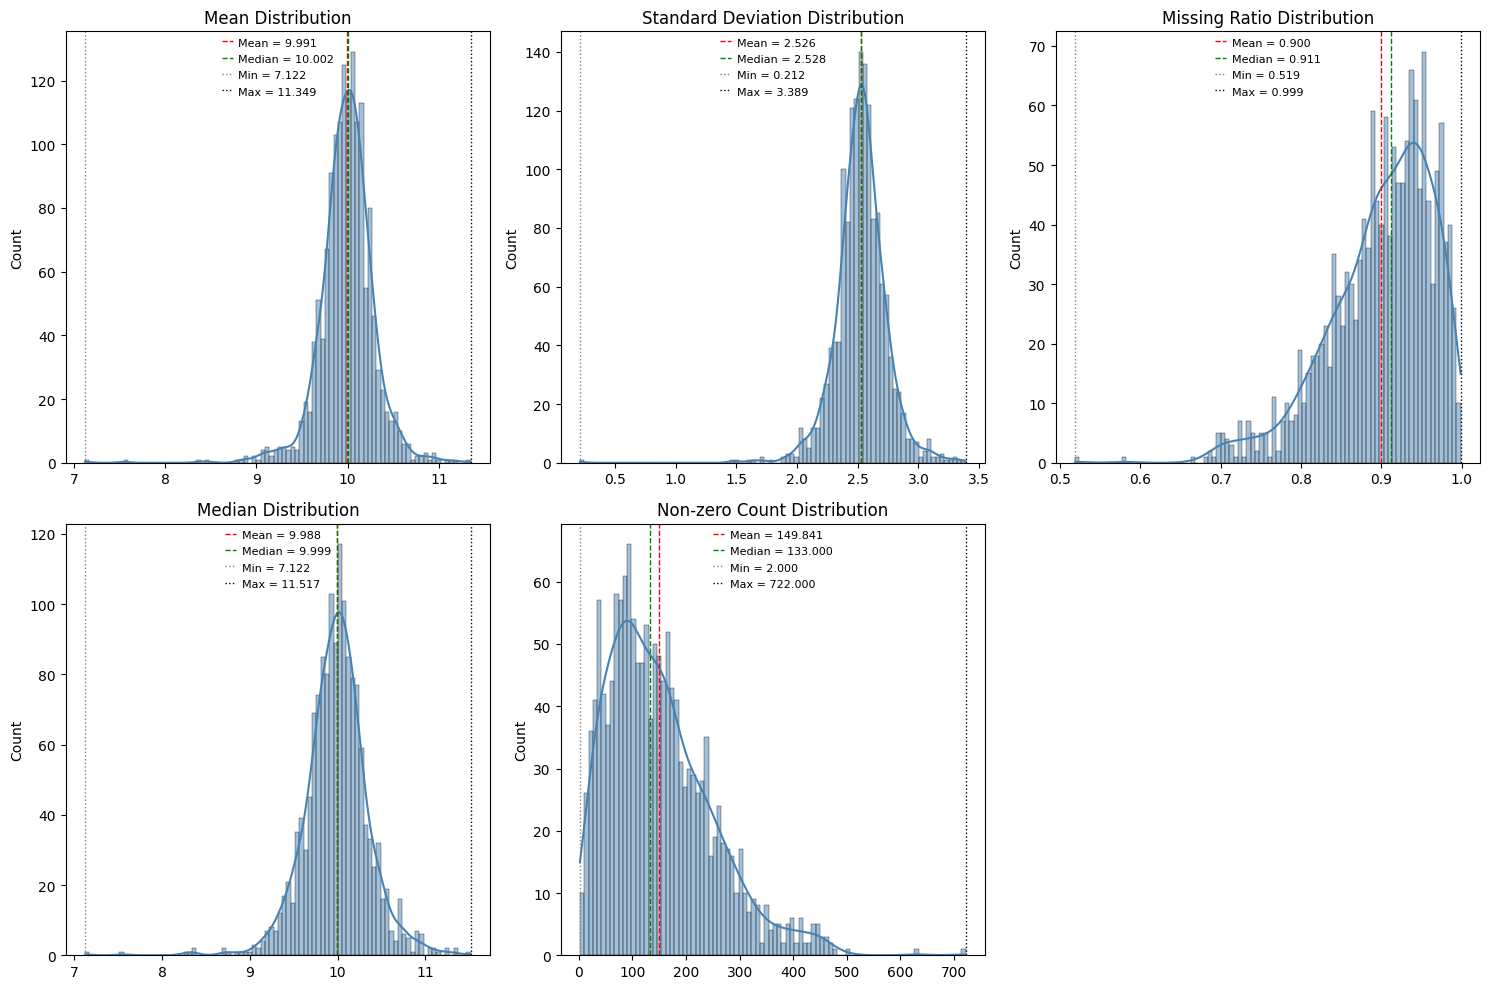

In [477]:
# Plot stats of data
def plot_hist_with_stats(data, ax, title, bins=90, color='steelblue'):
    sns.histplot(data, bins=bins, ax=ax, color=color, kde=True)
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('Count')

    mean_val = np.mean(data)
    median_val = np.median(data)
    min_val = np.min(data)
    max_val = np.max(data)

    # Draw vertical lines
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=1, label=f'Mean = {mean_val:.3f}')
    ax.axvline(median_val, color='green', linestyle='--', linewidth=1, label=f'Median = {median_val:.3f}')
    ax.axvline(min_val, color='gray', linestyle=':', linewidth=1, label=f'Min = {min_val:.3f}')
    ax.axvline(max_val, color='black', linestyle=':', linewidth=1, label=f'Max = {max_val:.3f}')

    ax.legend(fontsize=8)


# Calculate stats
!uv run calculate_stat.py simulated_data/simulated_scRNASeq_data.tsv simulated_data/simulated_scRNASeq_data_stats.tsv

stat_file = "simulated_data/simulated_scRNASeq_data_stats.tsv"

stat_df = pd.read_csv(stat_file, sep="\t", index_col=0)

# Some of the genes have all zero values. So the plot looks weird.
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

plot_hist_with_stats(stat_df['mean_log'], axs[0, 0], 'Mean Distribution')
plot_hist_with_stats(stat_df['std_log'], axs[0, 1], 'Standard Deviation Distribution')
plot_hist_with_stats(stat_df['missing_ratio'], axs[0, 2], 'Missing Ratio Distribution')
plot_hist_with_stats(stat_df['median_log'], axs[1, 0], 'Median Distribution')
plot_hist_with_stats(stat_df['n_nonzero'], axs[1, 1], 'Non-zero Count Distribution')

# Remove the last empty subplot
fig.delaxes(axs[1, 2])

plt.tight_layout()
plt.show()

In [478]:
# Run kale
!uv run kale.py simulated_data/simulated_scRNASeq_data.tsv simulated_data/simulated_prior_data.tsv simulated_data/_kale_scores.tsv

Not Weighted method selected; converting all weights to 1 or -1.
Using raw gene expression as input for per-cell ranking...
-> Using UNWEIGHTED mean rank calculation.
Starting TF activity using 8 cores.
Running in parallel with CORES_USED=8.
Processing cells in parallel: 100%|████████| 1500/1500 [00:01<00:00, 825.34it/s]
[Parallel(n_jobs=8)]: Done 1320 out of 1500 | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 1485 out of 1500 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done 1500 out of 1500 | elapsed:    2.2s finished

Aggregating results...
kale completed


In [479]:
# Gene Expression data
gene_exp_file = "simulated_data/simulated_scRNASeq_data.tsv"

gene_exp = pd.read_csv(gene_exp_file, sep="\t", index_col=0)
adata = sc.AnnData(gene_exp)
adata

AnnData object with n_obs × n_vars = 1500 × 1500

In [480]:
# Prior Knowledge Network
net_file = "simulated_data/simulated_prior_data.tsv"

effect_map = {"upregulates-expression": 1, "downregulates-expression": -1}

net = pd.read_csv(
    net_file,
    sep="\t",
    names=["source", "weight", "target"],
    usecols=[0, 1, 2],
    converters={"weight": effect_map.get}
)[["source", "target", "weight"]]

net.head()

,source,target,weight
0,TF_1,G_1025,1
1,TF_1,G_258,1
2,TF_1,G_1027,1
3,TF_1,G_1155,1
4,TF_1,G_1289,1


In [481]:
# Ground Truths
ground_truths_file = "simulated_data/simulated_ground_truth.tsv"

ground_truths = pd.read_csv(ground_truths_file, sep="\t", index_col=0)
ground_truths = ground_truths.reset_index().rename(columns={"index": "Cell"})
ground_truths = pd.melt(ground_truths, id_vars=["Cell"], var_name="TF", value_name="Value")
ground_truths["Cell_TF"] = ground_truths["Cell"] + "_" + ground_truths["TF"]
ground_truths = ground_truths[["Cell_TF", "Value"]]

print(f"Ground truths shape: {ground_truths.shape}")
print(ground_truths.head(10))

Ground truths shape: (105000, 2)
        Cell_TF  Value
0   Cell_1_TF_1      0
1   Cell_2_TF_1      0
2   Cell_3_TF_1      0
3   Cell_4_TF_1      0
4   Cell_5_TF_1      1
5   Cell_6_TF_1      0
6   Cell_7_TF_1      0
7   Cell_8_TF_1      0
8   Cell_9_TF_1      0
9  Cell_10_TF_1      0


In [482]:
methods_to_run = ["viper", "mlm", "ulm"]
dc.mt.decouple(adata, net, tmin=1, methods=methods_to_run)

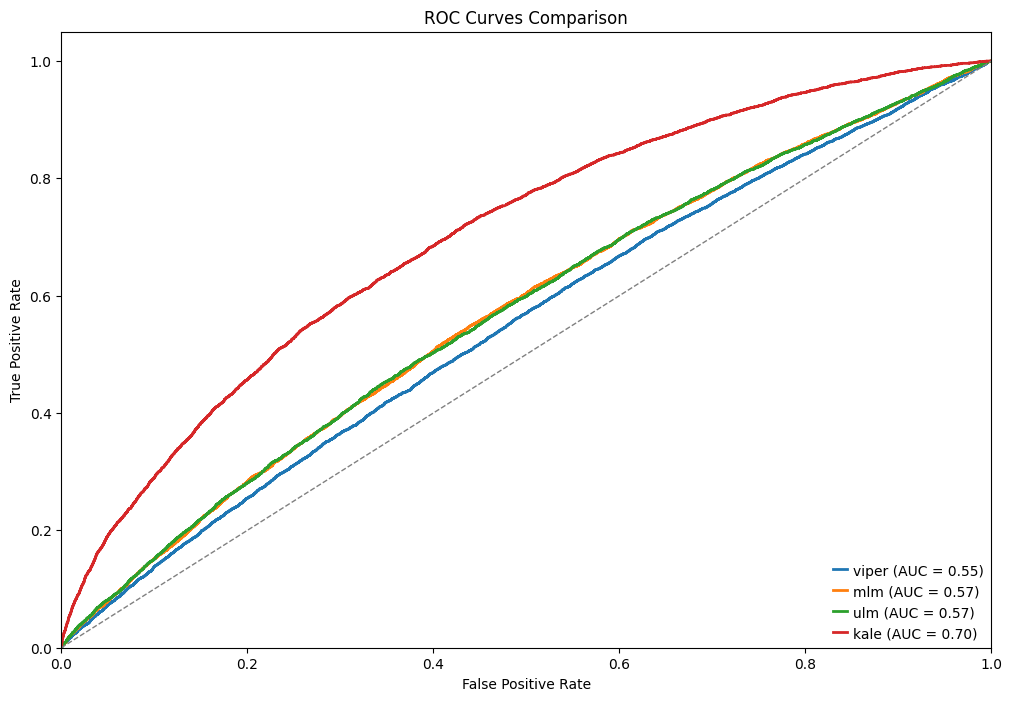

In [483]:
plt.figure(figsize=(12, 8))

methods_to_run.append("kale")

for method in methods_to_run:
    if method == "kale":
        method_scores = pd.read_csv("simulated_data/_kale_scores.tsv", sep="\t", index_col=0)

    else:
        # Get the scores for the current method
        method_scores = adata.obsm[f"score_{method}"]

    # Melt the DataFrame to long format
    scores_out = method_scores.reset_index().rename(columns={"index": "Cell"})
    scores_out = pd.melt(scores_out, id_vars=["Cell"], var_name="TF", value_name="Value")
    scores_out["Cell_TF"] = scores_out["Cell"] + "_" + scores_out["TF"]
    scores_out = scores_out[["Cell_TF", "Value"]]

    # Merge with ground truths
    scores_merged = scores_out.merge(ground_truths, on="Cell_TF", suffixes=("_pred", "_true"))

    # Sort by Cell_TF to ensure consistent ordering
    scores_merged = scores_merged.sort_values(by="Value_pred", ascending=False)
    scores_merged['y_true'] = (scores_merged['Value_true'] == 1.0).astype(int)

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(scores_merged['y_true'], scores_merged['Value_pred'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{method} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend(loc="lower right")
plt.show()